### Lista de exercícios - exercício 3

**Aluno:** André F. Oliveira

Este código se baseia no algoritmo desenvolvido para o exercício 1 com a diferença que o gerador de ruído e o pmodel. Ele não está incorporado diretamente no código, mas é carregado junto aos outros módulos no início do programa. O algoritmo do pmodel gera duas séries de famílias de sinais, a série endógena e a série exógena. A configuração para gerar cada família de sinais é: p = 0.32-0.42 e slope = 0.4 para a série endógena e p = 0.18-0.28 e slope = 0.7 para a série exógena. Os valores de slope já estão incorporados no código e não precisam ser fornecidos na execução do programa. O valores de p são gerados automaticamente e aleatoriamente nas faixas acima.

De maneira geral, o código realiza as seguintes operações:<br>
**1 -** Gera trinta sinais da endógenos e trintas sinais exógenos para três valores de p para cada série;<br>
**2 -** Calcula os momentos estatísticos destes sinais e os armazena em um dataframe;<br>
**3 -** Usa o algoritmo do k-means para agrupar os momentos estatísticos;<br>
**4 -** Exibe os gráficos com os resultados do k-means no espaço de parâmetros formados pelos momentos;<br>
**5 -** Identifica e mostra os sinais alocados em cada cluster;<br>
**6 -** Plota algum sinal de acordo com os valores de beta fornecidos pelo usuário;<br>
**7 -** Guarda os resultados em arquivos csv se o usuário assim escolher.<br>

In [17]:
import random
import numpy as np
import pandas as pd
from p_model import pmodel  # importando o pmodel
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import os
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11


def fold_creator(path):
    """
    Se o diretório não existe, cria o diretório com o valor de path
    """
    if not os.path.exists(path):
        os.makedirs(path)


def nome_unico(nome_arquivo):
    """
    Se o arquivo existe, adiciona um número ao seu nome.
    Ex: se momentos1.csv existe, cria arquivo momentos2.csv
    """
    f = 0
    while os.path.exists(nome_arquivo):
        f += 1
        ext = '.' + nome_arquivo.split('.')[1]
        num = int(nome_arquivo.split('.')[0][-1]) + f
        nome_arquivo = nome_arquivo.split('.')[0][:-1] + str(num) + ext
    return nome_arquivo


class GeradorSinal:
    """
    Simulador de ruídos com escala 1/f^beta
    """

    def __init__(self, n, sinais):
        """
        Inicializador dos parâmetros de entrada
        =======================================
        Inputs
        N: número de amostras
        beta: valor do expoente para cálculo do ruído - 0: ruído branco, 1: ruído rosa, 2: ruído vermelho
        sinais: quantidade de sinais a serem gerados para cada ruído
        """
        self.amostras = n
        self.n_sinais = sinais

        # Instâncias que serão declaradas nas funções
        self.dfy = None
        self.dfx = None

        # Listas para guardar os arquivos para serem salvos
        self.sinaisy = []
        self.sinaisx = []
        self.momentos = []
        self.k_means = []

        # Cria uma lista com valores aleatórios de p em um intervalo
        p_exo = sorted(random.sample([round(n, 2) for n in np.arange(0.18, 0.28, 0.01)], 3))
        p_end = sorted(random.sample([round(n, 2) for n in np.arange(0.32, 0.42, 0.01)], 3))
        p = [*p_exo, *p_end]

        # Executa o código para cada valor de p
        for n in p:
            self.sinal(n)

        self.kmeans()

        # Depois de executar todo o programa, pergunta se o usuário deseja plotar os sinais
        self.plot_sinais(p)

        # Depois de plotar os sinais, pergunta ao usuário se ele deseja salvar os arquivos csv
        salva = False
        while True:
            try:
                s = int(input('\n\nDeseja salvar os valores dos sinas em arquivos csv? (0- Não, 1- Sim): '))
            except ValueError:
                print('\n\nDigite 0 para não salvar e 1 para salvar os arquivos em formato csv')
                continue
            else:
                if s == 1:
                    salva = True
                    break
                elif s == 0:
                    break
                else:
                    print('\n\nDigite 0 para não salvar e 1 para salvar os arquivos em formato csv')
                    continue

        if salva:
            self.salva_arquivos()

    def sinal(self, p):

        tmpy = []
        tmpx = []
        for j in range(self.n_sinais):
            if 0.32 <= p <= 0.42:
                slope = -0.4
            elif 0.18 <= p <= 0.28:
                slope = -0.7
            # Note que o arquivo p_model.py deve estar no mesmo diretório
            x, y = pmodel(self.amostras, p, slope)
            tmpy.append(y-1)
            tmpx.append(x)

        self.dfy = pd.DataFrame(np.transpose(tmpy), columns=self.colnames(p)).astype('float64')
        self.dfx = pd.DataFrame(np.transpose(tmpx), columns=self.colnames(p)).astype('float64')
        self.sinaisy.append(self.dfy)
        self.sinaisx.append(self.dfx)

        # Chamando a próxima função
        self.momentos_estatisticos(p)

    def momentos_estatisticos(self, p):
        """
        Calcula os momentos estatísticos dos ruídos gerados pelo algoritmo powernoise
        """
        # Cria uma cópia do dataframe para ser utilizado somente dentro da função
        tmp = self.dfy.copy()

        # Altera o nome das colunas para uma melhor manipulação
        tmp.columns = [x for x in range(self.n_sinais)]

        # Função geradora de momentos
        f = lambda i, r: sum((tmp[i] - sum(tmp[i]) / len(tmp[i])) ** r)

        # Variancia
        var = []
        coeff_var = (1. / self.amostras)

        for i in range(self.n_sinais):
            var.append(coeff_var * f(i, 2))

        # Assimetria
        skew = []
        coeff_skew = (np.sqrt(self.amostras * (self.amostras - 1.)) / (self.amostras - 2.))

        for j in range(self.n_sinais):
            skew.append(coeff_skew * (coeff_var * f(j, 3) / var[j] ** 1.5))

        # Curtose
        coeff_kurt1 = ((self.amostras - 1.) * (self.amostras + 1.)) / ((self.amostras - 2.) * (self.amostras - 3.))
        coeff_kurt2 = 3. * ((self.amostras - 1.) ** 2.) / ((self.amostras - 2.) * (self.amostras - 3.))
        kurt = []

        for k in range(self.n_sinais):
            kurt.append(coeff_kurt1 * (coeff_var * f(k, 4) / var[k] ** 2.) - coeff_kurt2)

        df_stats = pd.DataFrame(np.transpose((self.colnames(p), var, skew, kurt)),
                                columns=['index', 'variance', 'skewness',
                                         'kurtosis']).set_index('index').astype('float64')

        # Guardando cada dataframe em uma lista
        self.momentos.append(df_stats)

    def kmeans(self):
        """
        Calcula o k-means para o dataset contendo os valores dos momentos estatísticos
        """

        # Carrega o dataset com os momentos estatísticos
        df_kmeans = pd.concat(self.momentos.copy())

        try:
            # Determinando o número ótimo de clusters
            model = KMeans()
            visualizer = KElbowVisualizer(model, k=(1, 10))
            visualizer.fit(df_kmeans)
            visualizer.show()
            
        except ValueError:
            print('Não foi observada uma variância nos momentos estatísticos. Tente novamente.')

        else:
            # Calculando o k-means
            n_clusters = visualizer.elbow_value_  # Número ótimo de clusters
            kmeans = KMeans(n_clusters=n_clusters)
            kmeans.fit(df_kmeans)
            df_kmeans['K_classes'] = kmeans.labels_
            self.k_means.append(df_kmeans)

            # Plotando as relações a pares de cada medida estatística (seaborn)
            plt.style.use("seaborn")
            colors = sns.color_palette('tab10', n_clusters)
            sns.pairplot(df_kmeans, 'K_classes', palette=colors)

            plt.show()

            # Plotando os pontos em 3 dimensões
            fig = plt.figure(figsize=(20, 15))
            ax = fig.add_subplot(111, projection='3d')

            labels = df_kmeans.groupby('K_classes')
            for key, item in labels:
                x = item['variance']
                y = item['skewness']
                z = item['kurtosis']

                ax.scatter(x, y, z, label=key, alpha=1, s=200, edgecolors='b', c=[colors[key]])

            # Plotandos os centróides em 3 dimensões
            x = []
            y = []
            z = []
            for row in kmeans.cluster_centers_:
                x.append(row[0])
                y.append(row[1])
                z.append(row[2])

            ax.scatter(x, y, z, alpha=0.4, s=500, label='Centróides')

            # Ajustando os eixos
            ax.set_xlabel('\n\n' + df_kmeans.columns[0], fontsize=20)
            ax.set_ylabel('\n\n' + df_kmeans.columns[1], fontsize=20)
            ax.set_zlabel('\n\n' + df_kmeans.columns[2], fontsize=20)
            ax.xaxis.set_tick_params(labelsize=18)
            ax.yaxis.set_tick_params(labelsize=18)
            ax.zaxis.set_tick_params(labelsize=18)

            plt.tight_layout()
            plt.legend(loc='best', fontsize=20)
            plt.show()

            # Mostra quais sinais estão em cada cluster
            for classe in pd.unique(df_kmeans['K_classes']):
                print(f'\n\n****************** Sinais na classe {classe} ******************')
                print(df_kmeans.loc[df_kmeans['K_classes'] == classe])

    def plot_sinais(self, p):
        """
        Plota um sinal e seu histograma correspondente à escolha do usuário
        """

        sinaisy = pd.concat(self.sinaisy, axis=1)
        sinaisx = pd.concat(self.sinaisx, axis=1)

        print('\n\t  Sinais gerados')
        print('\nSérie endógena\t\tSérie exógena')
        for index in range(int(len(sinaisy.columns) / 2)):
            index = index + 1
            print(f'{sinaisy.columns[-index]}\t\t{sinaisy.columns[index - 1]}')

        while True:
            try:
                s = int(input('\n\nDeseja plotar algum dos sinais? (0- Não, 1- Sim): '))
            except ValueError:
                print('\n\nDigite 0 para não plotar ou 1 para plotar')
                continue
            else:
                if s == 1:
                    try:
                        a = float(input('Valor de p: '))
                        b = int(input('Número da iteração: '))
                        if 0.18 <= a <= 0.28:
                            title = 'Série exógena'
                        elif 0.32 <= a <= 0.42:
                            title = 'Série endógena'
                    except ValueError:
                        print('\n\nValor inválido!')
                    else:
                        if not 'p:' + str(a) + ' ' + 'iter:' + str(b) in sinaisy.columns:
                            print('\n\nValores inválidos!')
                            continue
                        else:

                            for nome in sinaisy.columns:
                                valor_p = nome.split(' ')[0]
                                valor_iter = nome.split(' ')[1]
                                if 'p:' + str(a) == valor_p and 'iter:' + str(b) == valor_iter:
                                    gs = gridspec.GridSpec(2, 1)

                                    plt.figure(figsize=(12, 8))
                                    ax = plt.subplot(gs[0, :])
                                    plt.plot(sinaisy[valor_p + ' ' + valor_iter], color='cornflowerblue')
                                    ax.set_xlabel('Tempo (t)')
                                    ax.set_ylabel('Amplitude A(t)')
                                    ax.set_title(title)

                                    ax = plt.subplot(gs[1, :])
                                    plt.plot(sinaisx[valor_p + ' ' + valor_iter], color='burlywood')
                                    ax.set_xlabel('Tempo (t)')
                                    ax.set_ylabel('Amplitude A(t)')
                                    ax.set_title('Série fracionariamente integrada calculada a partir' \
                                                 ' do sinal acima')

                                    plt.tight_layout()
                                    plt.show()


                elif s == 0:
                    break

    def colnames(self, p):
        """
        Retorna uma lista com as strings dos valores de beta e sinal atuais
        """

        col = []
        for i in range(self.n_sinais):
            col.append('p:' + str(p) + ' ' + 'iter:' + str(i))

        return col

    def salva_arquivos(self):
        """
        Salva os arquivos em seus respectivos diretórios
        """

        # Cria o diretório para salvar os momentos estatísticos
        path = 'stats/'
        fold_creator(path)
        tmp = pd.concat(self.momentos.copy())
        nome_arquivo = path + 'momentos_0.csv'
        nome_arquivo = nome_unico(nome_arquivo)
        tmp.to_csv(nome_arquivo, index=True)

        # Cria o diretório para salvar os sinais de y
        path = 'sinais/'
        fold_creator(path)
        tmp = pd.concat(self.sinaisy.copy(), axis=1)
        nome_arquivo = path + 'sinaisy_0.csv'
        nome_arquivo = nome_unico(nome_arquivo)
        tmp.to_csv(nome_arquivo, index=True)

        # Salva o sinais de x no mesmo diretório
        path = 'sinais/'
        tmp = pd.concat(self.sinaisx.copy(), axis=1)
        nome_arquivo = path + 'sinaisx_0.csv'
        nome_arquivo = nome_unico(nome_arquivo)
        tmp.to_csv(nome_arquivo, index=True)

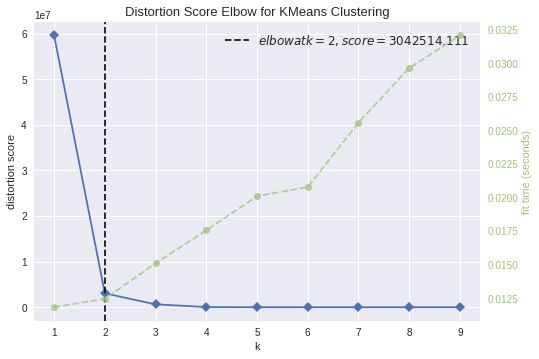

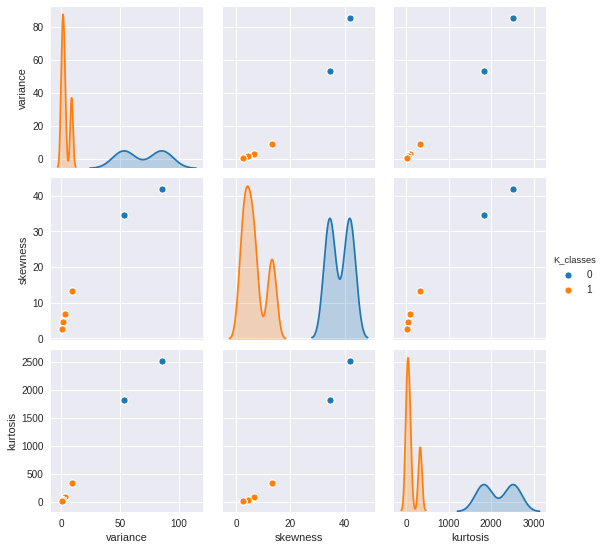

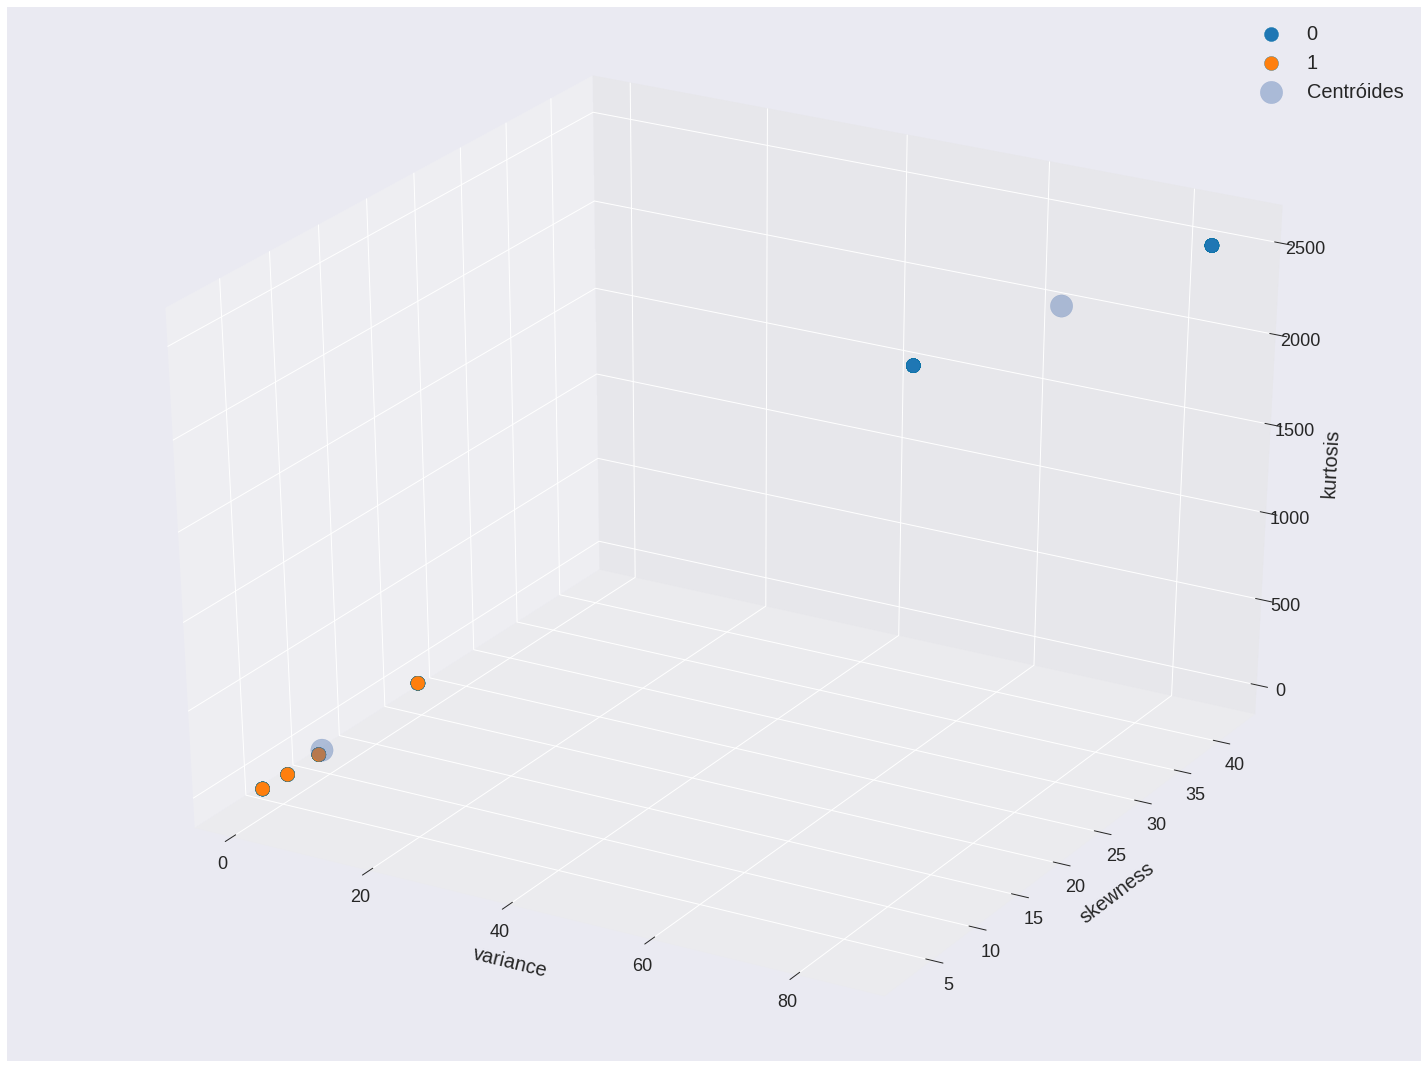



****************** Sinais na classe 0 ******************
                variance   skewness     kurtosis  K_classes
index                                                      
p:0.18 iter:0  85.745426  41.854886  2520.769431          0
p:0.18 iter:1  85.745426  41.854886  2520.769431          0
p:0.18 iter:2  85.745426  41.854886  2520.769431          0
p:0.18 iter:3  85.745426  41.854886  2520.769431          0
p:0.18 iter:4  85.745426  41.854886  2520.769431          0
p:0.18 iter:5  85.745426  41.854886  2520.769431          0
p:0.18 iter:6  85.745426  41.854886  2520.769431          0
p:0.18 iter:7  85.745426  41.854886  2520.769431          0
p:0.18 iter:8  85.745426  41.854886  2520.769431          0
p:0.18 iter:9  85.745426  41.854886  2520.769431          0
p:0.2 iter:0   53.450994  34.492265  1827.065962          0
p:0.2 iter:1   53.450994  34.492265  1827.065962          0
p:0.2 iter:2   53.450994  34.492265  1827.065962          0
p:0.2 iter:3   53.450994  34.492265  1827

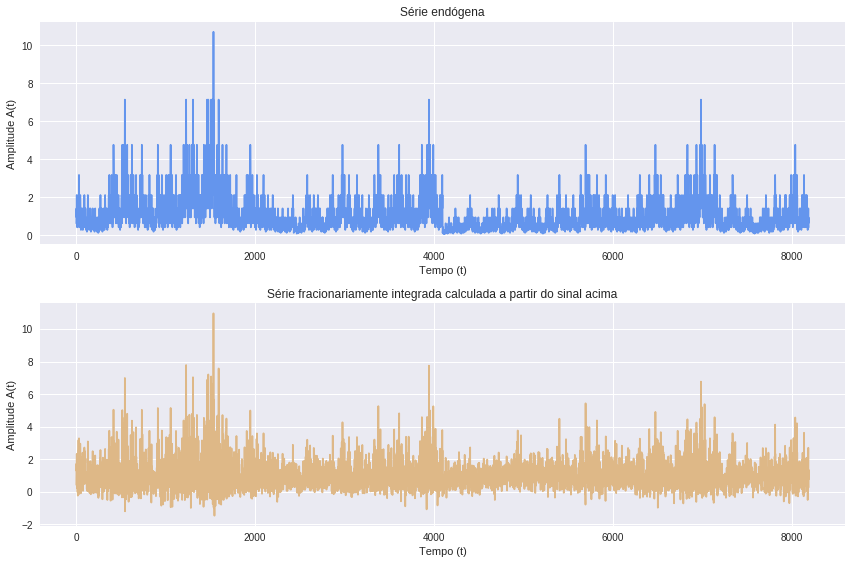



Deseja plotar algum dos sinais? (0- Não, 1- Sim): 1
Valor de p: 0.33
Número da iteração: 0


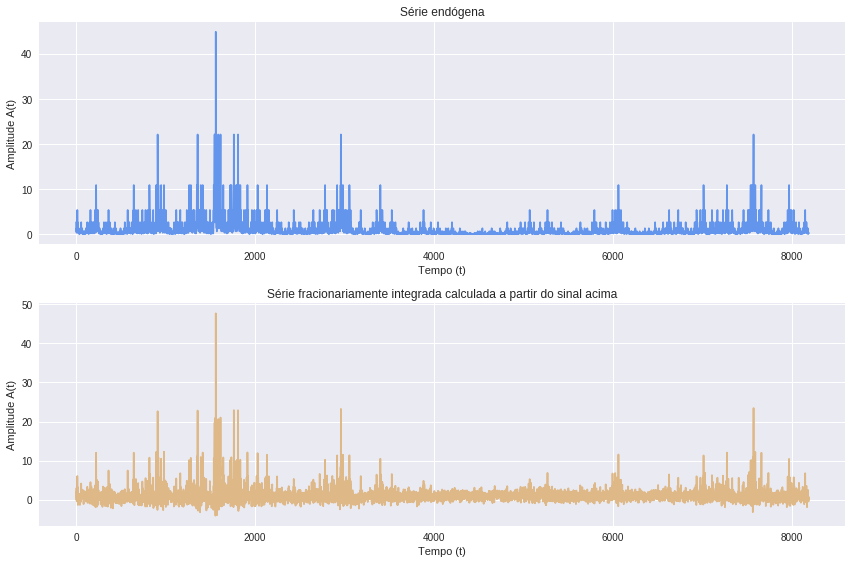



Deseja plotar algum dos sinais? (0- Não, 1- Sim): 1
Valor de p: 0.18
Número da iteração: 0


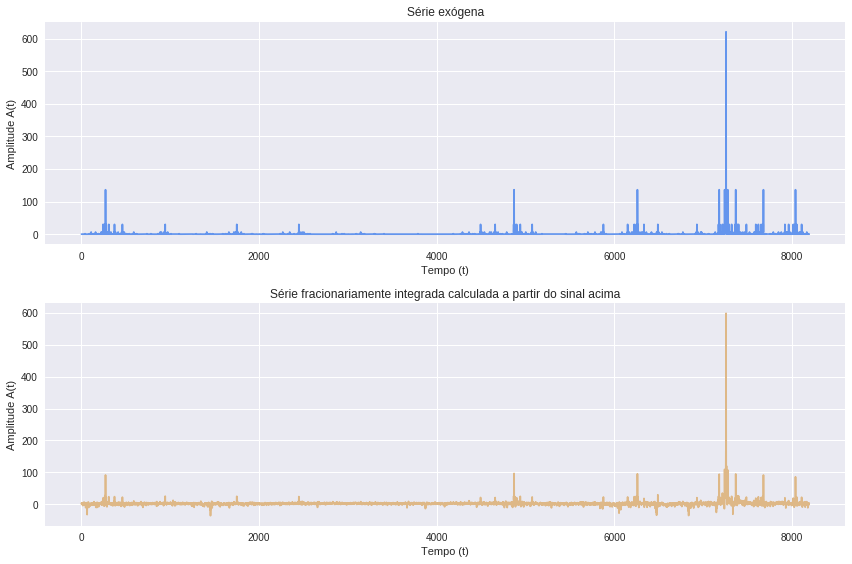



Deseja plotar algum dos sinais? (0- Não, 1- Sim): 1
Valor de p: 0.28
Número da iteração: 9


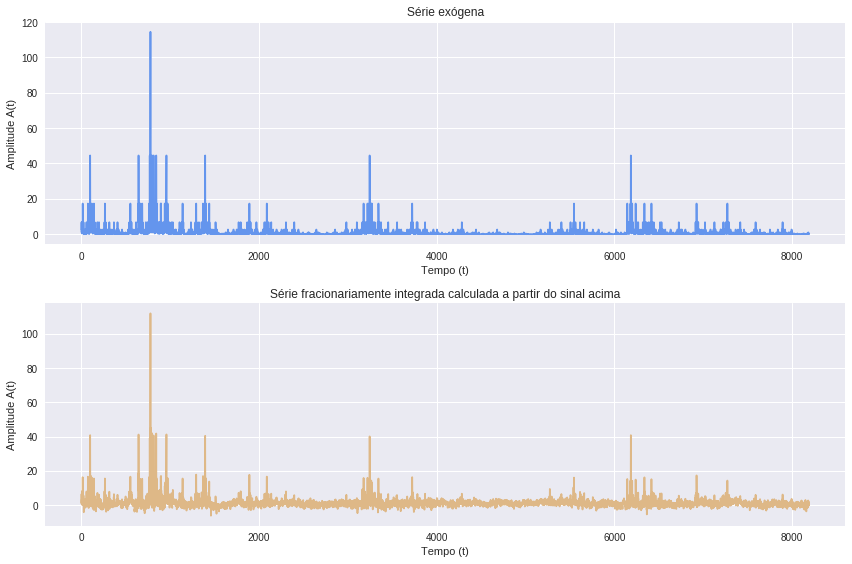



Deseja plotar algum dos sinais? (0- Não, 1- Sim): 0


Deseja salvar os valores dos sinas em arquivos csv? (0- Não, 1- Sim): 1


In [41]:
# Quantidade de pontos a serem gerados para cada série (endógena ou exógena)
N = 2**13

GeradorSinal(N, 10)

O resultado mais evidente deste algoritmo são os altos valores de momentos estatísticos, em especial a curtose, para os sinais exógenos. Uma inspeção na amplitude desses sinais ajuda a entender o motivo, já que eles são compostos por eventos extremos com valores de amplitude muito maiores com relação ao restante do sinal. Tais eventos dominam os valores dos momentos e dificultam até mesmo a classificação do algoritmo do k-means, já que todas as iterações têm, virtualmente, os mesmos valores de momento para um mesmo p e erros podem ocorrer devido a isto.